In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# === FILE NAMES ===
meas = pd.read_excel("measures.xlsx")      # columns: Ticker | Earnings Date | Jump | DM | QVS
own  = pd.read_excel("ownership.xlsx")     # columns: Ticker | Date | ETF Ownership %

# --- pulizia / normalizzazione ---
meas = meas.rename(columns={"Earnings Date":"EarningsDate"})
own  = own.rename(columns={"ETF Ownership %":"OwnershipPct"})

meas["Ticker"]       = meas["Ticker"].astype(str).str.strip()
own["Ticker"]        = own["Ticker"].astype(str).str.strip()
meas["EarningsDate"] = pd.to_datetime(meas["EarningsDate"], errors="coerce")
own["Date"]          = pd.to_datetime(own["Date"], errors="coerce")

def to_frac(x):
    if pd.isna(x): return np.nan
    if isinstance(x,str) and x.strip().endswith("%"):
        return float(x.strip().replace("%",""))/100
    x = float(x)
    return x/100 if x>1.5 else x

own["Ownership"] = own["OwnershipPct"].apply(to_frac)

# tieni solo righe valide
meas = meas.dropna(subset=["Ticker","EarningsDate"])
own  = own.dropna(subset=["Ticker","Date","Ownership"])

# --- MERGE ROBUSTO: per-ticker, con chiavi ordinate ---
merged = []
tickers = sorted(set(meas["Ticker"]) & set(own["Ticker"]))
for t in tickers:
    m = (meas.loc[meas["Ticker"]==t]
              .sort_values("EarningsDate")
              .reset_index(drop=True))
    o = (own.loc[own["Ticker"]==t, ["Date","Ownership"]]
             .sort_values("Date")
             .reset_index(drop=True))
    if o.empty:
        m["Ownership"] = np.nan
        merged.append(m)
        continue
    mm = pd.merge_asof(
        m, o,
        left_on="EarningsDate", right_on="Date",
        direction="backward",  # ultima ownership <= EarningsDate
        allow_exact_matches=True
    ).drop(columns=["Date"])
    merged.append(mm)

# aggiungi anche eventuali ticker che hanno solo misure (nessuna ownership)
only_meas_tickers = set(meas["Ticker"]) - set(tickers)
if only_meas_tickers:
    merged.append(meas[meas["Ticker"].isin(only_meas_tickers)].assign(Ownership=np.nan))

panel = (pd.concat(merged, ignore_index=True)
           .dropna(subset=["Ownership","Jump","DM","QVS"])
           .sort_values(["Ticker","EarningsDate"])
           .reset_index(drop=True))

# effetti fissi temporali
panel["Year"]    = panel["EarningsDate"].dt.year
panel["Quarter"] = panel["EarningsDate"].dt.to_period("Q").astype(str)

print(panel.head())

# --- Regressioni: Y ~ Ownership + FE(Year) + FE(Ticker), SE cluster per Ticker ---
def run(y):
    f = f"{y} ~ Ownership + C(Year) + C(Ticker)"
    m = smf.ols(f, data=panel).fit(cov_type="cluster", cov_kwds={"groups": panel["Ticker"]})
    print(f"\n=== {y} ===")
    print(m.summary().tables[1])
    print(f"R2={m.rsquared:.3f}  adjR2={m.rsquared_adj:.3f}  F p-val={m.f_pvalue:.4g}")
    return m

m_jump = run("Jump")
m_dm   = run("DM")
m_qvs  = run("QVS")

panel.to_excel("panel_ready.xlsx", index=False)

    Ticker EarningsDate  Used Date    Jump     DM    QVS  Ownership  Year  \
0  3800-HK   2015-08-28 2015-08-28  1.6124  94.61  87.19   0.043849  2015   
1  3800-HK   2016-03-23 2016-03-23  1.1837  96.34  93.62   0.034741  2016   
2  3800-HK   2016-08-24 2016-08-24  0.2656  99.58  99.74   0.041837  2016   
3  3800-HK   2017-03-29 2017-03-29  1.2743  97.99  92.11   0.043782  2017   
4  3800-HK   2017-05-17 2017-05-17  1.9809  97.74  82.65   0.050991  2017   

  Quarter  
0  2015Q3  
1  2016Q1  
2  2016Q3  
3  2017Q1  
4  2017Q2  

=== Jump ===
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1.0058      0.118      8.495      0.000       0.774       1.238
C(Year)[T.2016]           -0.1358      0.143     -0.947      0.344      -0.417       0.145
C(Year)[T.2017]            0.0308      0.179      0.172      0.863      -0.319       0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 11
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 11
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 39, but rank is 11
  warnings.warn('covariance of constraints does not have full '


I 10 titoli più illiquidi sono: ['VRT-US', 'AMSC-US', 'AMRC-US', 'ENPH-US', 'DQ-US', 'AA-US', 'RUN-US', 'NEX-FR', 'HASI-US', 'NVT-US']


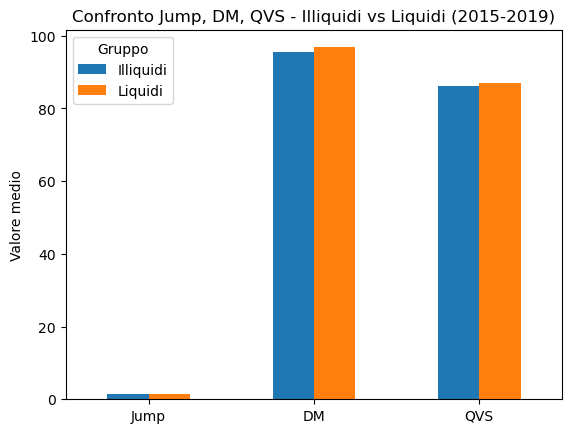

               Jump         DM        QVS
Group                                    
Illiquidi  1.366761  95.655213  86.119096
Liquidi    1.337506  96.842147  87.037276


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# === Carica lista ticker ===
tickers = pd.read_excel("earnings_dates.xlsx")["Ticker"].unique()

# === Calcola Amihud medio (2015-2019) per ogni ticker ===
amihud_means = []
for t in tickers:
    try:
        df = pd.read_csv(f"{t}.csv", thousands=",")
        df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y", errors="coerce")
        df = df.sort_values("Date")
        
        # Filtra periodo 2015-2019
        df = df[(df["Date"] >= "2015-01-01") & (df["Date"] <= "2019-12-31")]
        
        # Pulizia colonne numeriche
        for col in ["Price", "Vol."]:
            df[col] = (
                df[col].astype(str)
                .str.replace(",", "")
                .str.replace("M", "e6")
                .str.replace("K", "e3")
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        # Calcola rendimenti
        df["Return"] = df["Price"].pct_change()
        
        # Amihud giornaliero
        df["Amihud"] = df["Return"].abs() / (df["Price"] * df["Vol."])
        
        amihud_mean = df["Amihud"].mean()
        amihud_means.append({"Ticker": t, "Amihud_mean": amihud_mean})
    except Exception as e:
        print(f"Errore con {t}: {e}")
        continue

df_amihud = pd.DataFrame(amihud_means)
df_amihud

# === Z-score e selezione top 10 illiquidi ===
df_amihud["Amihud_z"] = zscore(df_amihud["Amihud_mean"], nan_policy="omit")
illiquid_tickers = df_amihud.nlargest(10, "Amihud_z")["Ticker"].tolist()
print("I 10 titoli più illiquidi sono:", illiquid_tickers)


# === Carica misure già calcolate ===
df_measures = pd.read_excel("measures.xlsx")


df_measures["Group"] = np.where(df_measures["Ticker"].isin(illiquid_tickers), "Illiquidi", "Liquidi")

# === Calcolo medie per sottogruppo ===
df_grouped = df_measures.groupby("Group")[["Jump", "DM", "QVS"]].mean()


# Supponiamo di avere anche una colonna 'Amihud' oltre a Jump, DM, QVS
df['Amihud_z'] = zscore(df['Amihud'])

# Definiamo due gruppi: illiquidi (z-score alto) e liquidi (z-score basso)
df['Group'] = df['Amihud_z'].apply(lambda x: 'Illiquidi' if x > 0 else 'Liquidi')

# Plot
df_grouped.T.plot(kind="bar")
plt.title("Confronto Jump, DM, QVS - Illiquidi vs Liquidi (2015-2019)")
plt.ylabel("Valore medio")
plt.xticks(rotation=0)
plt.legend(title="Gruppo")
plt.show()

print(df_grouped)


In [3]:
#1. Carico i dati dal file Excel
panel = pd.read_excel("panel_ready.xlsx")

#2. Pulizia: uniformo i ticker
panel["Ticker"] = panel["Ticker"].astype(str).str.strip()
df_measures["Ticker"] = df_measures["Ticker"].astype(str).str.strip()

#3. Aggiungi colonna 'Group' dal df_measures
panel = pd.merge(
    panel,
    df_measures[["Ticker", "Group"]].drop_duplicates(),
    on="Ticker",
    how="left"
)

print(panel.head())

    Ticker EarningsDate  Used Date    Jump     DM    QVS  Ownership  Year  \
0  3800-HK   2015-08-28 2015-08-28  1.6124  94.61  87.19   0.043849  2015   
1  3800-HK   2016-03-23 2016-03-23  1.1837  96.34  93.62   0.034741  2016   
2  3800-HK   2016-08-24 2016-08-24  0.2656  99.58  99.74   0.041837  2016   
3  3800-HK   2017-03-29 2017-03-29  1.2743  97.99  92.11   0.043782  2017   
4  3800-HK   2017-05-17 2017-05-17  1.9809  97.74  82.65   0.050991  2017   

  Quarter    Group  
0  2015Q3  Liquidi  
1  2016Q1  Liquidi  
2  2016Q3  Liquidi  
3  2017Q1  Liquidi  
4  2017Q2  Liquidi  


In [4]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_illiquidi = panel[panel['Group'] == 'Illiquidi'].copy()

# Definisco le variabili target
metrics = ['Jump', 'DM', 'QVS']

for metric in metrics:
    print(f"\n================= REGRESSIONE: {metric} ~ Ownership (Illiquidi) =================")

    # Definisco y e X
    y = pd.to_numeric(df_illiquidi[metric], errors='coerce')
    X = pd.to_numeric(df_illiquidi['Ownership'], errors='coerce')
    df_reg = pd.DataFrame({'Ownership': X, metric: y}).dropna()

    y = df_reg[metric]
    X = sm.add_constant(df_reg[['Ownership']])

    # Regressione OLS
    model = sm.OLS(y, X).fit()

    # Calcolo VIF
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Output
    print(model.summary())
    print("\n=== VIF ===")
    print(vif_df)


model_qr = smf.quantreg("Jump ~ Ownership", data=df_illiquidi).fit(q=0.5)
print(model_qr.summary())

from scipy.stats import spearmanr

corr, pval = spearmanr(df_reg["Ownership"], df_illiquidi["Jump"])
print(f"Spearman correlation = {corr:.3f}, p-value = {pval:.4f}")



================= REGRESSIONE: Jump ~ Ownership (Illiquidi) =================
                            OLS Regression Results                            
Dep. Variable:                   Jump   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     10.45
Date:                Sat, 13 Sep 2025   Prob (F-statistic):            0.00134
Time:                        16:23:19   Log-Likelihood:                -558.79
No. Observations:                 370   AIC:                             1122.
Df Residuals:                     368   BIC:                             1129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [5]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import spearmanr, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_illiquidi = panel[panel['Group'] == 'Illiquidi'].copy()
metrics = ['Jump', 'DM', 'QVS']

for metric in metrics:
    print(f"\n================= REGRESSIONE: {metric} ~ Ownership (Illiquidi) =================")

    # Pulizia dati
    y = pd.to_numeric(df_illiquidi[metric], errors='coerce')
    X = pd.to_numeric(df_illiquidi['Ownership'], errors='coerce')
    df_reg = pd.DataFrame({'Ownership': X, metric: y}).dropna()

    y = df_reg[metric]
    X = sm.add_constant(df_reg[['Ownership']])

    # Regressione OLS
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # VIF
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n=== VIF ===")
    print(vif_df)

    # Test di Jarque-Bera
    jb_stat, jb_pval = jarque_bera(model.resid)
    print(f"\n=== JB test === JB stat = {jb_stat:.3f}, p-value = {jb_pval:.4g}")
    if jb_pval < 0.05:
        print("❌ Residui NON normali → serve un test robusto o non parametrico.")
    else:
        print("✅ Residui normalmente distribuiti.")

    # Regressione Quantile
    model_qr = smf.quantreg(f"{metric} ~ Ownership", data=df_reg).fit(q=0.5)
    print("\n=== Quantile Regression (q=0.5) ===")
    print(model_qr.summary())

    # Spearman correlation
    corr, pval = spearmanr(df_reg["Ownership"], df_reg[metric])
    print(f"\n=== Spearman correlation = {corr:.3f}, p-value = {pval:.4f}")


================= REGRESSIONE: Jump ~ Ownership (Illiquidi) =================
                            OLS Regression Results                            
Dep. Variable:                   Jump   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     10.45
Date:                Sat, 13 Sep 2025   Prob (F-statistic):            0.00134
Time:                        16:23:19   Log-Likelihood:                -558.79
No. Observations:                 370   AIC:                             1122.
Df Residuals:                     368   BIC:                             1129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [6]:
df_liquidi = panel[panel['Group'] == 'Liquidi'].copy()

# Definisco le variabili target
metrics = ['Jump', 'DM', 'QVS']

for metric in metrics:
    print(f"\n================= REGRESSIONE: {metric} ~ Ownership (Liquidi) =================")

    # 3. Definisco y e X
    y = pd.to_numeric(df_liquidi[metric], errors='coerce')
    X = pd.to_numeric(df_liquidi['Ownership'], errors='coerce')
    df_reg = pd.DataFrame({'Ownership': X, metric: y}).dropna()

    y = df_reg[metric]
    X = sm.add_constant(df_reg[['Ownership']])

    # 4. Regressione OLS
    model = sm.OLS(y, X).fit()

    # 5. Calcolo VIF
    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # 6. Output
    print(model.summary())
    print("\n=== VIF ===")
    print(vif_df)


================= REGRESSIONE: Jump ~ Ownership (Liquidi) =================
                            OLS Regression Results                            
Dep. Variable:                   Jump   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2558
Date:                Sat, 13 Sep 2025   Prob (F-statistic):              0.613
Time:                        16:23:20   Log-Likelihood:                -913.36
No. Observations:                 613   AIC:                             1831.
Df Residuals:                     611   BIC:                             1840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------